# Differential Expression with DESeq

The aim is to determine whether the read count differences between different conditions for a given gene are greater
than expected by chance. We are using DESeq/DESeq2 R package. (Anders and Huber, 2010; Love et al., 2014)

http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#indfilt

To run this notebook you need the DESeqDataSet object generated on previous task, ReadQuantification to DESeqDataSet.

This notebook makes use of funtions to programatically analise different conditions in one go. An alternative is to work with the notebook Task4_DifferentialAnalysis_step_by_step for a detailed protocol.

Note that the dataset used to illustrate this pipeline is synthetic data, the phenotypes and genotypes were randomly assigned and results may not make much sense.

In [1]:
suppressPackageStartupMessages(library(DESeq2))

In [2]:
path="/mnt/data/GWES/RNAseq/output/ASTRO_DUMMY/STAR"

In [3]:
load(paste(path,"DESeq_object",sep="/"))

In [4]:
head(assay(DESeq.ds))

,S10,S27,S28,S29,S30,S31,S32,S33,S35,S36,S37,S38,S39,S40
ENSG00000227232,1,0,0,1,0,0,0,0,0,1,0,0,0,0
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,0,0,1,0
ENSG00000268903,0,2,0,3,1,1,1,2,0,3,0,1,2,0
ENSG00000269981,0,0,1,2,1,1,0,0,1,0,0,0,0,0
ENSG00000241860,0,0,2,0,1,0,0,0,0,0,0,0,0,2
ENSG00000279457,1,2,1,2,4,3,1,1,4,1,2,5,0,2


In [5]:
dim(assay(DESeq.ds))

[1] 33105    14

## Running the DGE analysis with DESeq2

A linear model could be done using the function lm(log.norm.counts ∼genotype). Instead of using a linear model, DESeq2 and edgeR rely on a negative binomial model to fit the observed read counts to arrive at the estimate for the difference. Read counts had been modeled using the Poisson distribution.

The convenient feature of a Poisson distribution is that variance=mean. Thus, if the RNA-seq experiment gives us a precise estimate of the mean read counts per condition, we implicitly know what kind of variance to expect for read counts that are not truly changing between two conditions. This, in turn, then allows us to identify those genes that show greater differences between the two conditions than expected by chance.

### Functions

In [6]:
# Plots a heatmap with the input dataset
# heatmapset:  expression dataset for top DE genes
heatmap_function<-function(heatmapset,title){
    suppressPackageStartupMessages(library(gplots))
    heatmap.2(as.matrix(heatmapset), scale = "row", trace="none",cexRow=0.5,cexCol=0.5,main=title)  
}

In [7]:
# Plots a heatmap with the input dataset
# heatmapset:  expression dataset for DE genes
aheatmap_function<-function(heatmapset,title,labcol){
    suppressPackageStartupMessages(library(NMF))
    # rlog-normalized read counts for genes that show differential expression with adjusted p-values <0.05
    # heatmapset columns have the same order as rows in colData(DEseq) (as colnames(countdata)=rownames(sampleinfo))
    aheatmap(heatmapset ,Rowv = TRUE , Colv = TRUE ,distfun = "euclidean", hclustfun = "average",scale = "row",labCol=labcol,main=title)
    #scale="row" means values are transformed into distances from the center of the row-specific average: (actual value - mean of the group) / standard deviati
}

In [9]:
# Plots a pca
# variable: pca group variable
pca_function<- function(countdata,sampleinfo,variable) {
    suppressPackageStartupMessages(library(ggplot2))
    suppressPackageStartupMessages(library(grid))
    suppressPackageStartupMessages(library(gridExtra))

    pca <- prcomp(t(countdata))
    pca2 <- as.data.frame(pca$x)
    pca2$group <- sampleinfo[[variable]] # if group is a number, the legend in plot is a color gradient

    theme<-theme(panel.background = element_blank(),panel.border=element_rect(fill=NA),panel.grid.major = element_blank(),panel.grid.minor = element_blank(),strip.background=element_blank(),axis.text.x=element_text(colour="black"),axis.text.y=element_text(colour="black"),axis.ticks=element_line(colour="black"),plot.margin=unit(c(1,1,1,1),"line"))
    p<-ggplot(pca2,aes(x=PC1,y=PC2,color=group))
    p<-p+geom_point() +theme
    plot(p)
}    

In [11]:
# Annotation
annot <- read.table("/mnt/data/GWES/RNAseq/ref_files/annotation_hsapiens_ensembl_symbol")
head(annot,n=3)

,ensembl_gene_id,hgnc_symbol
,<chr>,<chr>
1,ENSG00000210049,MT-TF
2,ENSG00000211459,MT-RNR1
3,ENSG00000210077,MT-TV


In [12]:
# translate ensembl IDs to gene symbols. 
# It removes genes with no hgnc_symbol and removes duplicates symbol, keeping the one with best pvalue
# 1st parameter: DEG table
# 2nd parameter: annotation table from Biomart
annotate_function<-function(dataset,annot){
    annot.merge=merge(dataset,annot, by.x="row.names",by.y="ensembl_gene_id")
    
    annot.merge=annot.merge[!annot.merge$hgnc_symbol=="", ] # remove genes with no translation to mgi symbol
    annot.merge<-annot.merge[with(annot.merge, order(pvalue)), ] # order by best pvalue
    annot.merge<-annot.merge[!duplicated(annot.merge$hgnc_symbol), ] # remove duplicated mgi_symbol, keeping the one with best padj
    dataset.annotated=annot.merge[, -c(which(names(annot.merge)=="hgnc_symbol"),which(names(annot.merge)=="Row.names"))]
    rownames(dataset.annotated)=annot.merge$hgnc_symbol
    # rank
    rank<-rank(dataset.annotated$pvalue,na.last = TRUE, ties.method = "min")
    ranked<-cbind(rank,dataset.annotated)
    
    #return(dataset.annotated)
    return(ranked)
}

### Differential Expression functions

Decide the contrast you want to test for and execute the DE for all at once.

In [13]:
# create the contrats you want apply
contrast.list = list(c("ApoE_group","ApoE2","ApoE3"), c("ApoE_group","ApoE4","ApoE3"), c("ApoE_group","ApoE4","ApoE2"),c("ApoE_group","ApoE4","KO"))


In [14]:
# create the contrats you want apply
contrast.status.list = list(c("Status","Case","Control"))

**If we keep in the DESeq object just the genotypes to compare and then remove genes with 0 counts in all samples we can easily end up with no samples at all. This subsetting is not needed - not using this functions.**

### DE analysis

In [15]:
outpath="/mnt/data/GWES/RNAseq/output/ASTRO_DUMMY/diffExpr"
dir.create(file.path(outpath))

In [16]:
head(data.frame(colData(DESeq.ds)))

,Samplename,ApoE_group,ApoE_genotype,Sex,Status
,<chr>,<fct>,<chr>,<chr>,<chr>
S10,S10,ApoE3,E3E3,Female,Case
S27,S27,ApoE2,E2E2,Female,Control
S28,S28,ApoE2,E2E2,Female,Control
S29,S29,ApoE2,E2E2,Female,Control
S30,S30,ApoE4,E3E4,Female,Case
S31,S31,ApoE4,E3E4,Male,Case


In [17]:
dim(assay(DESeq.ds))
head(assay(DESeq.ds))

[1] 33105    14

,S10,S27,S28,S29,S30,S31,S32,S33,S35,S36,S37,S38,S39,S40
ENSG00000227232,1,0,0,1,0,0,0,0,0,1,0,0,0,0
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,0,0,1,0
ENSG00000268903,0,2,0,3,1,1,1,2,0,3,0,1,2,0
ENSG00000269981,0,0,1,2,1,1,0,0,1,0,0,0,0,0
ENSG00000241860,0,0,2,0,1,0,0,0,0,0,0,0,0,2
ENSG00000279457,1,2,1,2,4,3,1,1,4,1,2,5,0,2


The results function of the DESeq2 package performs independent filtering by default using the mean of normalized counts as a filter statistic. A threshold on the filter statistic is found which optimizes the number of adjusted p values lower than a significance level alpha (we use the standard variable name for significance level, though it is unrelated to the dispersion parameter α). The theory behind independent filtering is discussed in greater detail below. **The adjusted p values for the genes which do not pass the filter threshold are set to NA.**

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




==  ApoE2vsApoE3  ==

- Summary -

out of 33105 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4883, 15%
LFC < 0 (down)     : 4817, 15%
outliers [1]       : 0, 0%
low counts [2]     : 13479, 41%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

      rank  baseMean log2FoldChange      lfcSE      stat pvalue padj
KLF6     1  2237.900      -2.156582 0.04944227 -43.61818      0    0
P4HA2    1  2895.660      -2.486350 0.05010837 -49.61945      0    0
ENO1     1 17419.660      -1.507690 0.03717153 -40.56034      0    0
FBLN1    1  1295.134       6.916704 0.16649620  41.54271      0    0
FTL      1  9894.557      -1.712354 0.03891191 -44.00591      0    0
ACTA2    1  5296.808       4.654409 0.06508086  71.51731      0    0


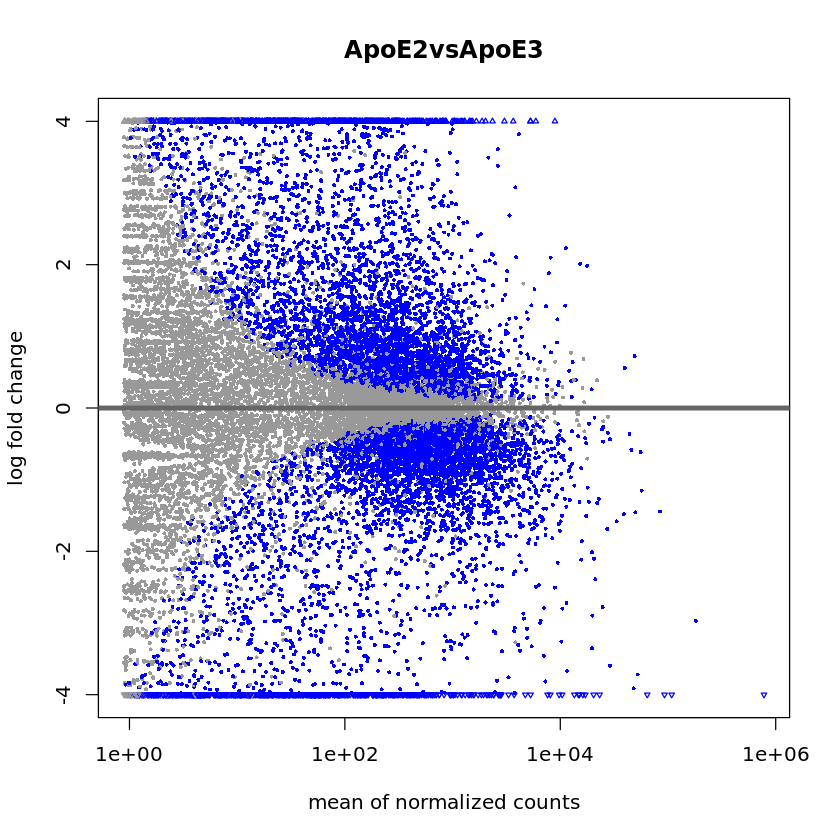

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



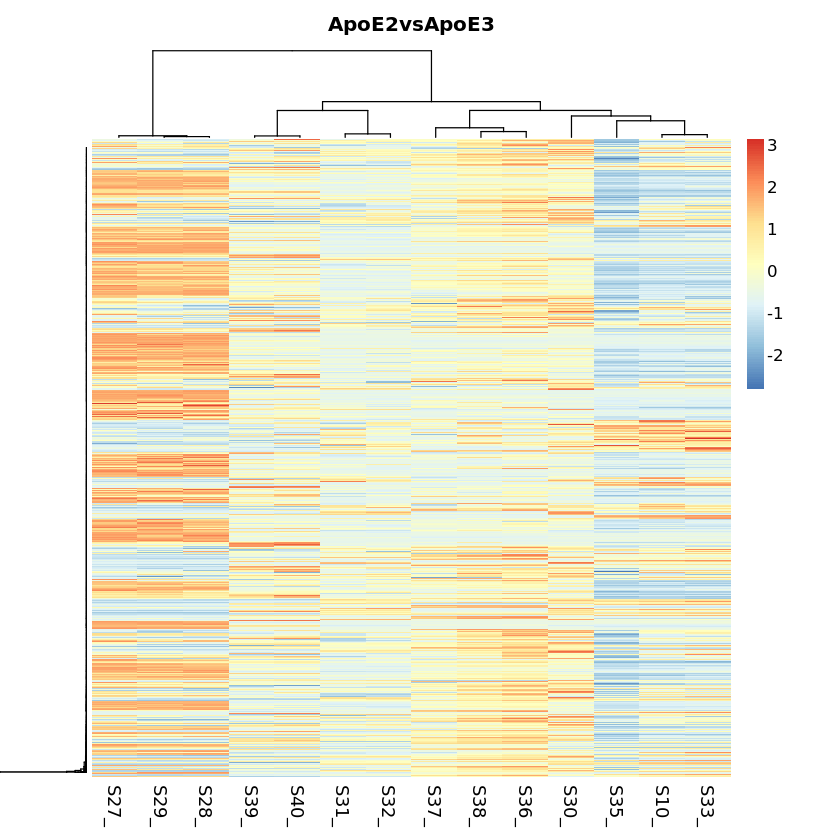


==  ApoE4vsApoE3  ==

- Summary -

out of 33105 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3563, 11%
LFC < 0 (down)     : 3256, 9.8%
outliers [1]       : 0, 0%
low counts [2]     : 14762, 45%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

         rank  baseMean log2FoldChange      lfcSE      stat        pvalue
CAV2        1 1260.9797       3.124726 0.08189780  38.15397  0.000000e+00
ACTA2       1 5296.8081       2.448783 0.06115680  40.04105  0.000000e+00
PDE1C       1 2476.8422      -2.373337 0.05225296 -45.42014  0.000000e+00
ADAMTS5     1  758.6968      -3.769768 0.07928041 -47.54980  0.000000e+00
TNFRSF21    5  950.0796      -2.829988 0.07836744 -36.11178 1.481913e-285
CCND2       6 1685.2439      -2.117536 0.06299563 -33.61402 1.046683e-247
                  padj
CAV2      0.000000e+00
ACTA2     0.000000e+00
PDE1C     0.000000e+00
ADAMTS5   0.000000e+00
TNFRSF21 5.436545e-282
CCND2 

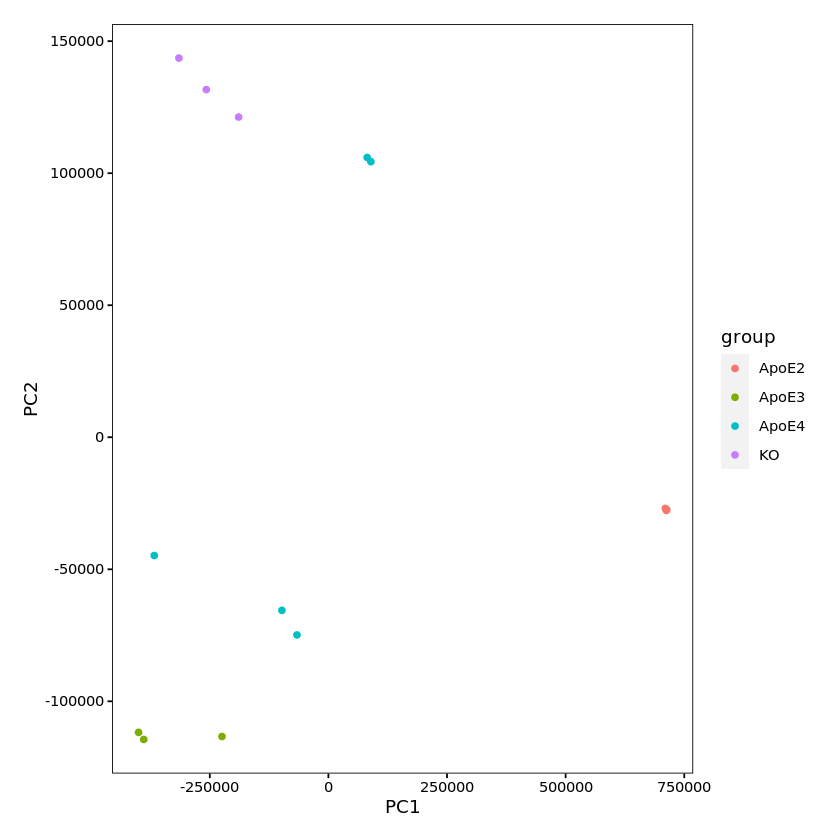

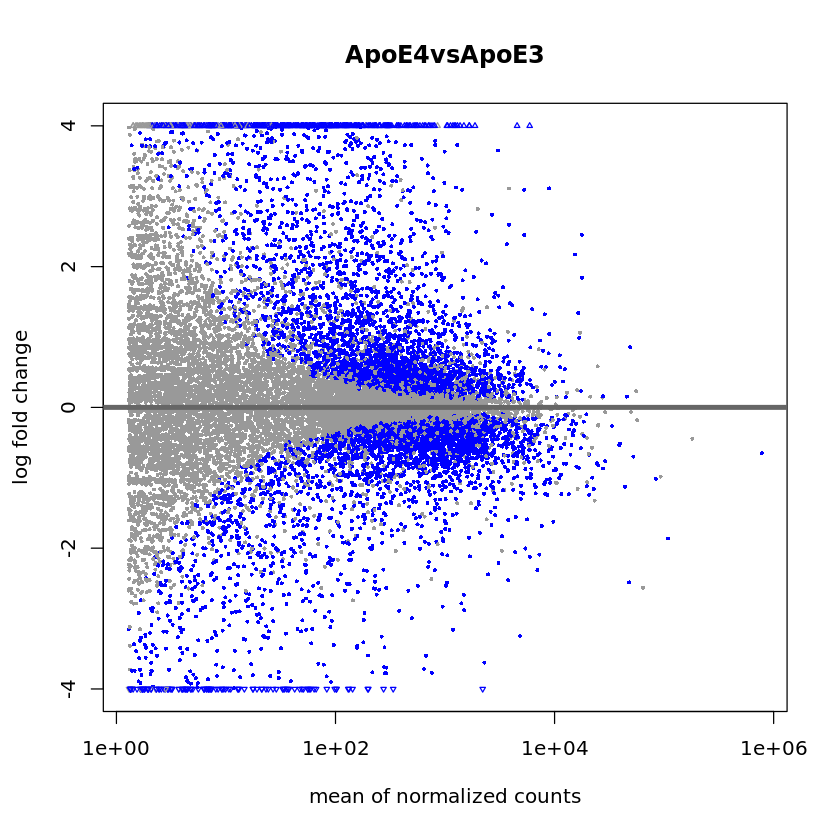

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



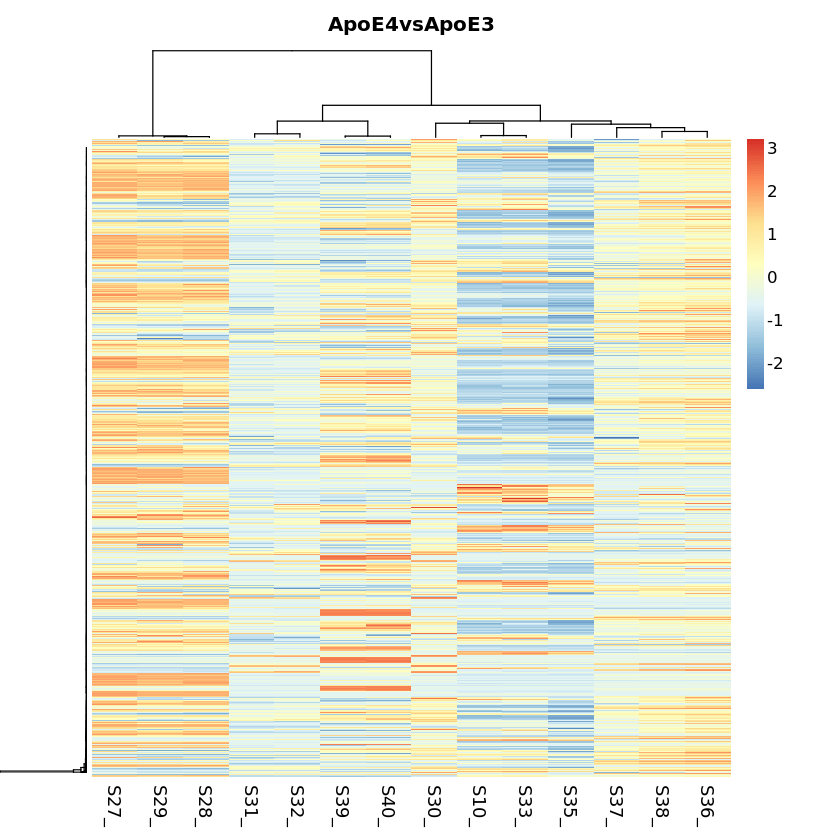


==  ApoE4vsApoE2  ==

- Summary -

out of 33105 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4746, 14%
LFC < 0 (down)     : 4358, 13%
outliers [1]       : 0, 0%
low counts [2]     : 12837, 39%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

      rank   baseMean log2FoldChange      lfcSE      stat pvalue padj
KLF6     1  2237.8998       1.905366 0.04539762  41.97062      0    0
P4HA2    1  2895.6595       1.765993 0.04625134  38.18252      0    0
ENO1     1 17419.6595       1.741622 0.03322618  52.41717      0    0
FBLN1    1  1295.1336      -3.187196 0.05922020 -53.81940      0    0
PTN      1   624.9125      -3.063503 0.07625081 -40.17666      0    0
ACTA2    1  5296.8081      -2.205626 0.04965820 -44.41615      0    0


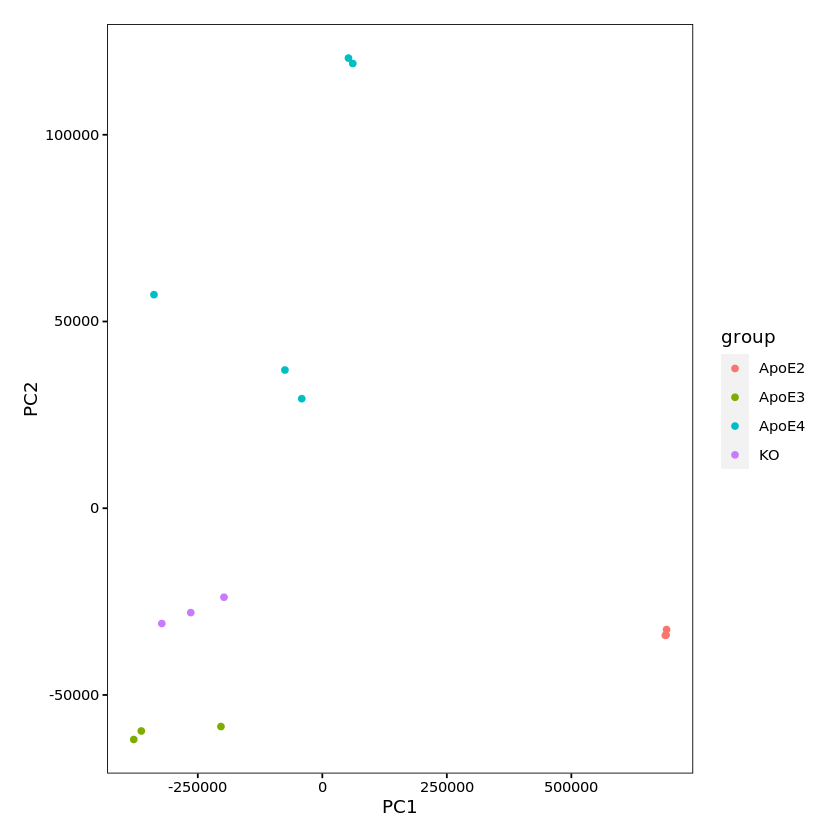

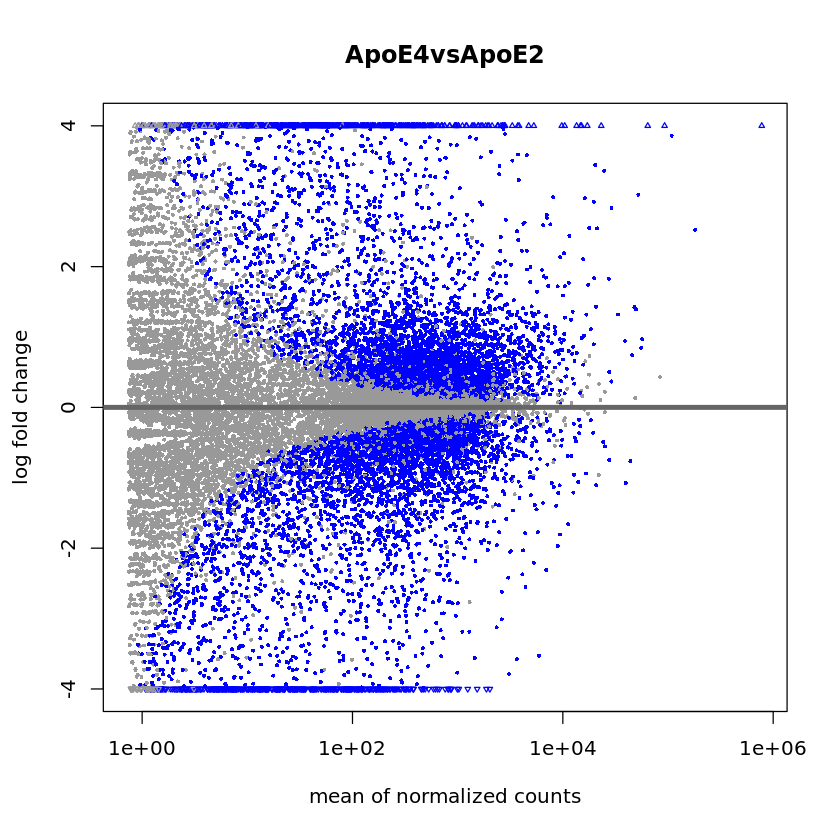

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



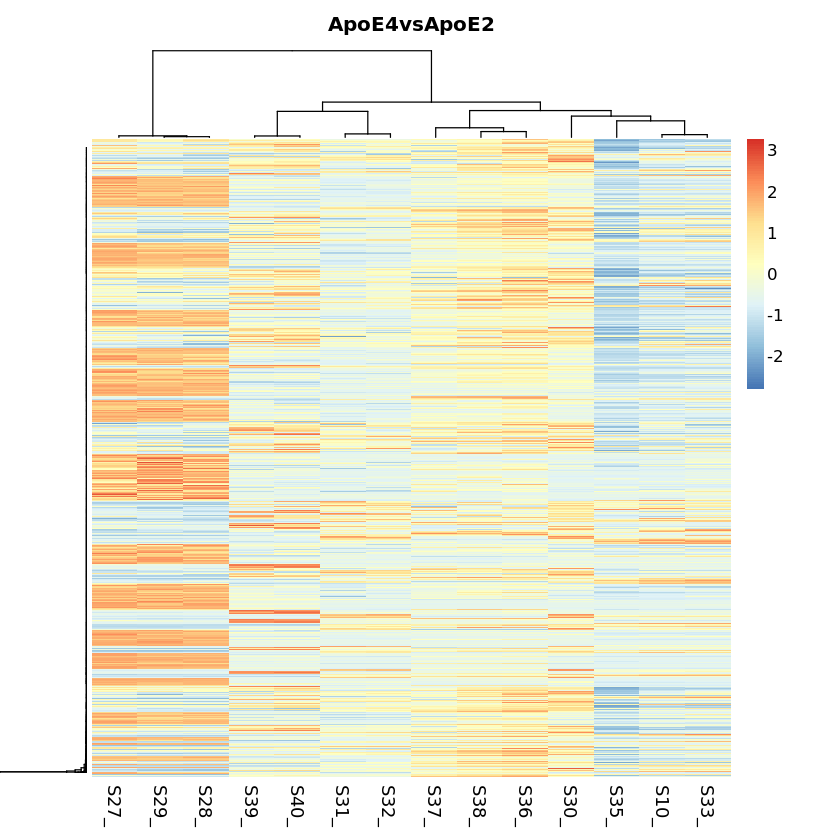


==  ApoE4vsKO  ==

- Summary -

out of 33105 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2804, 8.5%
LFC < 0 (down)     : 2085, 6.3%
outliers [1]       : 0, 0%
low counts [2]     : 14762, 45%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

       rank  baseMean log2FoldChange      lfcSE      stat        pvalue
DUSP4     1  869.6781      -4.781278 0.08683797 -55.05977  0.000000e+00
PDE1C     1 2476.8422      -2.279090 0.05182379 -43.97769  0.000000e+00
MYBL1     1 1011.4833      -3.027848 0.05919598 -51.14955  0.000000e+00
SEMA5A    4 2626.8955      -2.764268 0.07499589 -36.85893 2.103861e-297
GDF5      5  397.0975      -2.809764 0.08001886 -35.11378 4.154050e-270
CAMK1D    6  791.6651      -1.979371 0.05842173 -33.88074 1.280420e-251
                padj
DUSP4   0.000000e+00
PDE1C   0.000000e+00
MYBL1   0.000000e+00
SEMA5A 9.647783e-294
GDF5   1.523955e-266
CAMK1D 3.914458e-248


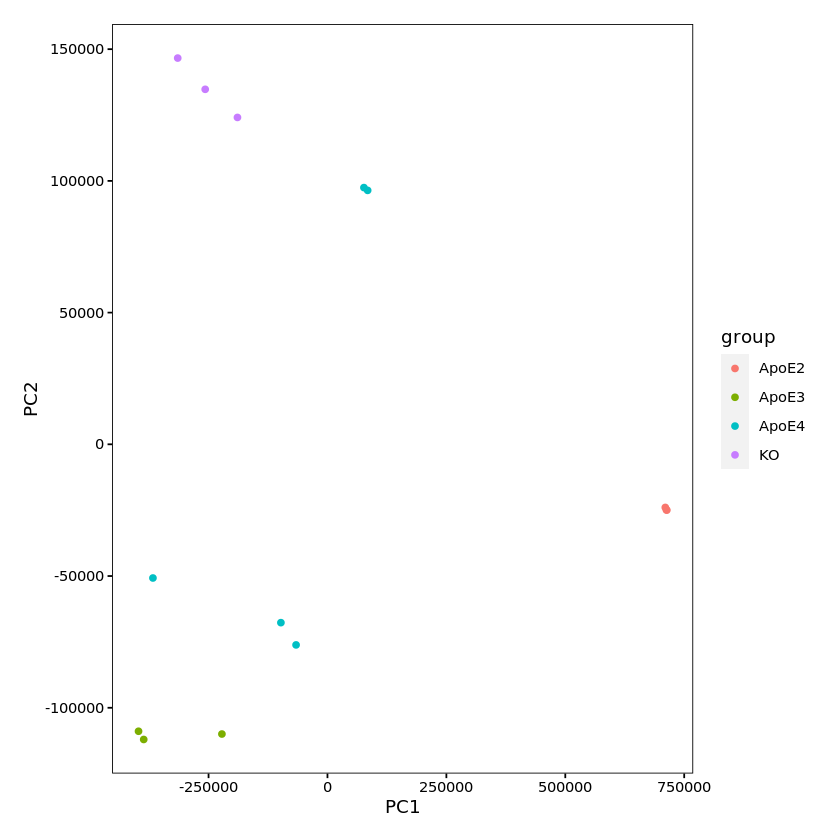

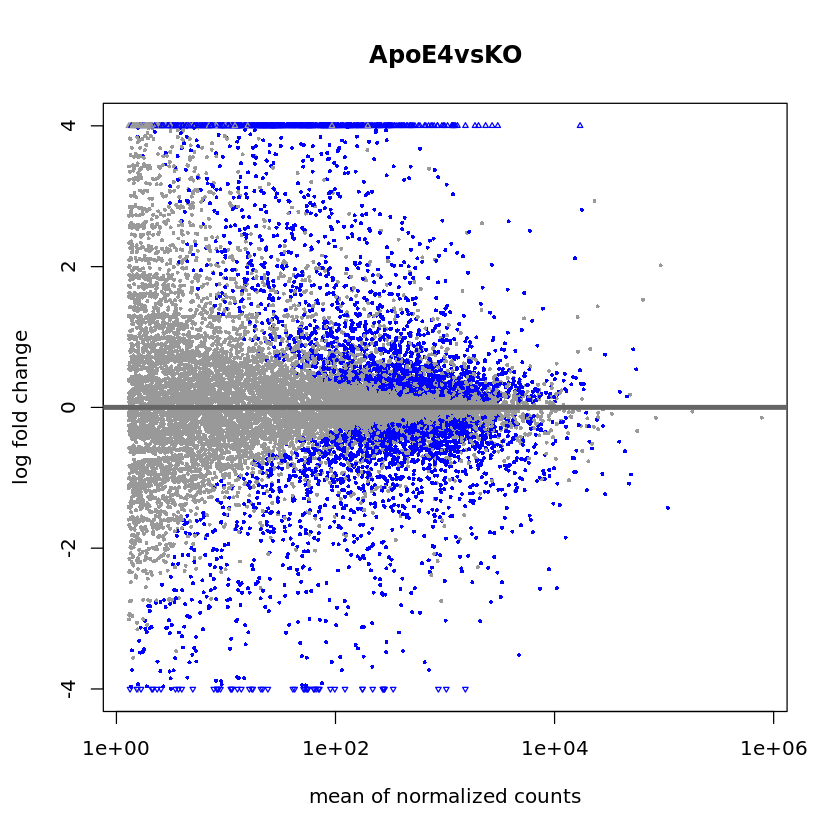

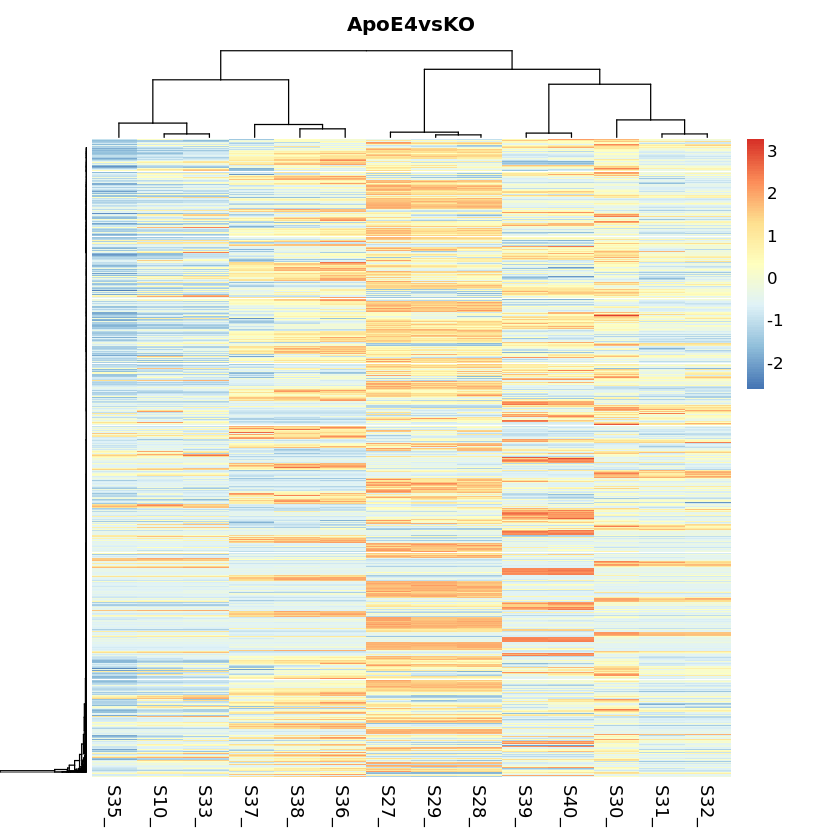

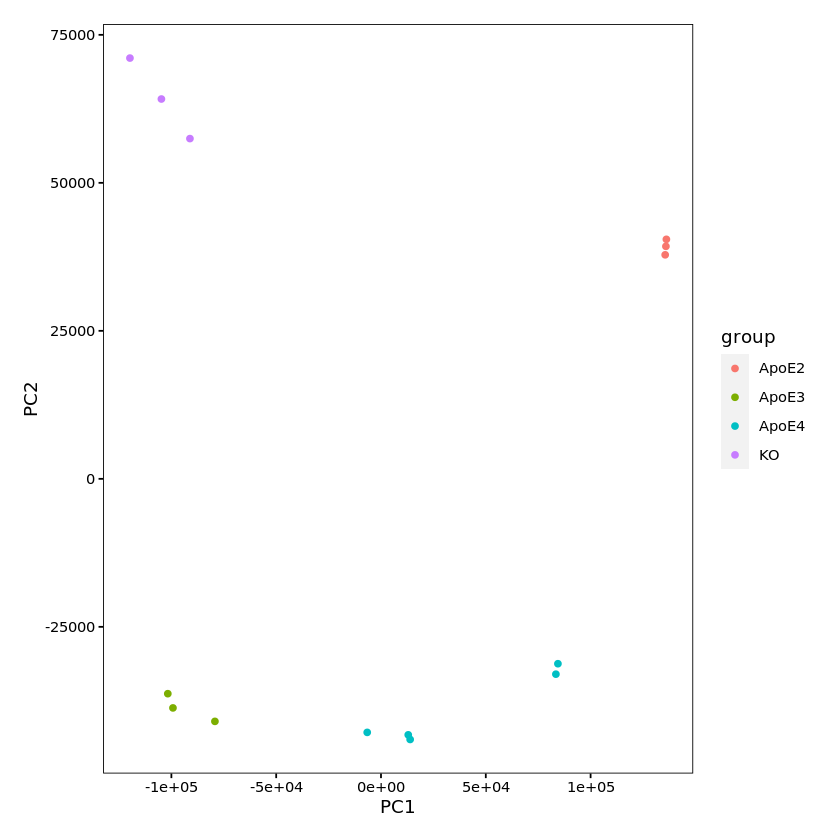

In [23]:
for (i in 1:length(contrast.list)){
    # DE analysis with DESeq2
    # Either use createDESeqObject function or create the DESeq object with the original data
    #DESeq.geno=createDESeqObject(data.frame(colData(DESeq.ds)),assay(DESeq.ds),contrast[[i]])
    DESeq <- DESeqDataSetFromMatrix(countData = assay(DESeq.ds) ,
                                    colData = data.frame(colData(DESeq.ds)) ,
                                    design = ~ ApoE_group ) # + any other covariates
    DESeq.analysis=DESeq(DESeq)
    contrast.title=paste(gsub("/","",contrast.list[[i]][2]),"vs",gsub("/","",contrast.list[[i]][3]),sep="")
    cat("\n== ",contrast.title," ==\n")
    
    # get results
    DGE.results  <- results(DESeq.analysis, alpha = 0.05, contrast = contrast.list[[i]])
    cat("\n- Summary -\n")
    summary(DGE.results)
    #remove genes with padj to NA (= genes that do not pass the low count filter)
    DGE.results.clean=DGE.results[!is.na(DGE.results$padj) ,]
    #cat("\n- Summary after removing genes that do not pass the low count filter -\n")
    #summary(DGE.results.clean)
    results.annot=annotate_function(data.frame(DGE.results.clean),annot)
    print(head(results.annot))
    
    # plot MA with genes passing the low count filter. 
    #The MA plot shows the relationship between the expression change (M) and average expression strength (A); genes with adjusted p-values <0.05 are marked in red.
    plotMA(DGE.results.clean , alpha = 0.05,  main = contrast.title, ylim = c(-4,4))
    
    # identify  DE genes  with  the  desired  adjusted p-value cut -off to plot heatmap and PCA
    DGEgenes  <- rownames(subset(DGE.results.clean , padj < 0.05))
    if(length(DGEgenes)==0){
        DGEgenes=rownames(DGE.results.clean[1:50 ,])
        cat("There are no genes with adj pvalue above 0.05. Showing the top 50 in the heatmap")
    }
    heatmapset=assay(DESeq)[DGEgenes,]  
    labcol=paste(colnames(heatmapset),colData(DESeq)$ApoEtype,sep="_")
    aheatmap_function(heatmapset,title = contrast.title,labcol) # one-line function ? does not make much sense
    pca_function(heatmapset,colData(DESeq),"ApoE_group")
    
    # write results with ensembl Id and annotated
    #write.table(data.frame(DGE.results[order(DGE.results$pvalue) ,]),paste(outpath,contrast.title,sep="/"))
    write.table(results.annot,paste(outpath,paste(contrast.title,"annot",sep="_"),sep="/"))
    
    # Write summary to file to be able to plot pct low counts
    capture.output(summary(DGE.results),file=paste(outpath,paste(contrast.title,"summary",sep="."),sep="/"))

}  

#### Plot percentage of low counts per analysis

In [20]:
source("scripts/lowCountDEseqPlot.R")

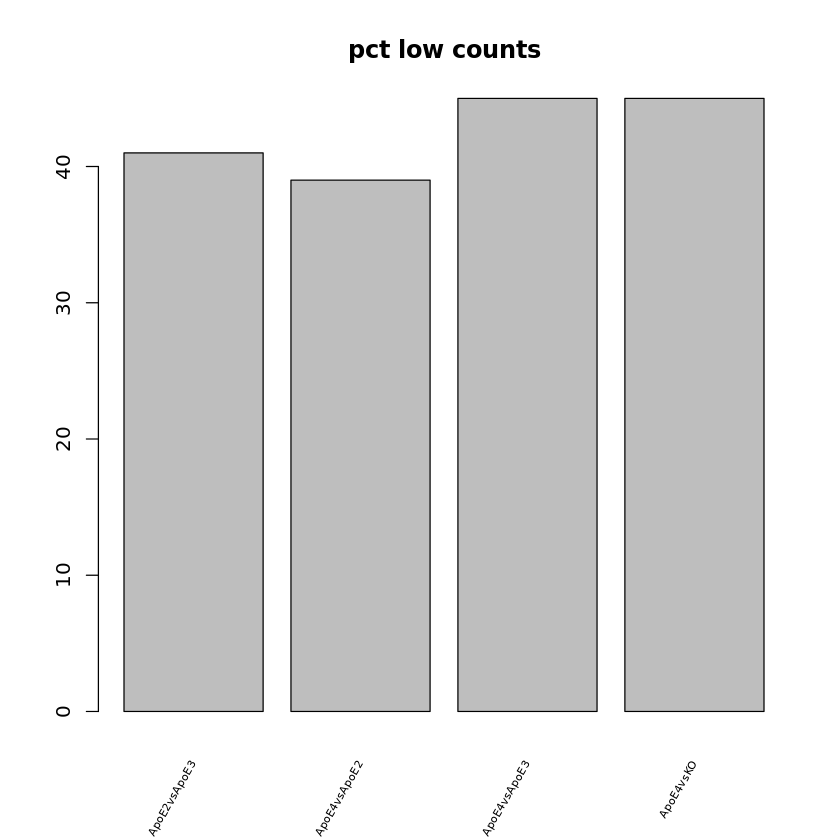

In [24]:
pct_low_counts_function(outpath)